In [1]:
# Copilot-written code to parse zgaz_perf.log

import re

log_path = "zgaz_perf_kl_15.log"
RESULTS_TRUNCATE = 400

# Regular expressions for parsing
iter_re = re.compile(r"Training iteration (\d+) of \d+")
examples_re = re.compile(r"Training on (\d+) examples")
batches_re = re.compile(r"Training with (\d+) batches of size (\d+)")
epoch1_loss_re = re.compile(r"Epoch 1/.*, Train Loss: ([\d.]+).*, Train Mean Max: ([\d.]+)")
epoch5_loss_re = re.compile(r"Epoch 5/.*, Train Loss: ([\d.]+).*, Train Mean Max: ([\d.]+)")
epoch10_loss_re = re.compile(r"Epoch 10/.*, Train Loss: ([\d.]+).*, Train Mean Max: ([\d.]+)")
epoch20_loss_re = re.compile(r"Epoch 20/.*, Train Loss: ([\d.]+).*, Train Mean Max: ([\d.]+)")
reward_line_re = re.compile(r'^(Old network\+MCTS|New network\+MCTS|Old bare network|New bare network|External policy ".*?") average reward: ([\d.\-]+), min: ([\d.\-]+), max: ([\d.\-]+), stdev: ([\d.\-]+)')
win_pct_re = re.compile(r"New network won (\d+) and tied (\d+) out of (\d+) games \(([\d.]+)% wins where ties are half wins\)")
decision_re = re.compile(r"(Reverting to the old network|Keeping the new network)")
# Timing regexes
games_time_re = re.compile(r"\.\.games done in ([\d.]+) seconds")
train_time_re = re.compile(r"\.\.training done in ([\d.]+) seconds")
eval_time_re = re.compile(r"\.\.evaluation done in ([\d.]+) seconds")

results = []
reward_label_order = []  # Track order of first appearance

with open(log_path, "r") as f:
    entry = {}
    for line in f:
        if m := iter_re.search(line):
            if entry:
                results.append(entry)
                entry = {}
            entry["iteration"] = int(m.group(1))
        if m := examples_re.search(line):
            entry["examples"] = int(m.group(1))
        if m := batches_re.search(line):
            entry["batches"] = int(m.group(1))
        if m := epoch1_loss_re.search(line):
            entry["epoch1_loss"] = float(m.group(1))
            entry["epoch1_mean_max"] = float(m.group(2))
        if m := epoch5_loss_re.search(line):
            entry["epoch5_loss"] = float(m.group(1))
            entry["epoch5_mean_max"] = float(m.group(2))
        if m := epoch10_loss_re.search(line):
            entry["epoch10_loss"] = float(m.group(1))
            entry["epoch10_mean_max"] = float(m.group(2))
        if m := epoch20_loss_re.search(line):
            entry["epoch20_loss"] = float(m.group(1))
            entry["epoch20_mean_max"] = float(m.group(2))
        if m := reward_line_re.search(line):
            if "rewards" not in entry:
                entry["rewards"] = {}
            label = m.group(1)
            avg = float(m.group(2))
            minv = float(m.group(3))
            maxv = float(m.group(4))
            stdev = float(m.group(5))
            entry["rewards"][label] = {
                "avg": avg,
                "min": minv,
                "max": maxv,
                "stdev": stdev
            }
            if label not in reward_label_order:
                reward_label_order.append(label)
        if m := win_pct_re.search(line):
            entry["win_pct"] = float(m.group(4))
        if m := decision_re.search(line):
            entry["decision"] = "keep" if "Keeping" in m.group(1) else "revert"
        if m := games_time_re.search(line):
            entry["games_time"] = float(m.group(1))
        if m := train_time_re.search(line):
            entry["train_time"] = float(m.group(1))
        if m := eval_time_re.search(line):
            entry["eval_time"] = float(m.group(1))
    if entry:
        results.append(entry)

# Example: print the first 3 parsed entries
for r in results[:3]:
    print(r)

if RESULTS_TRUNCATE is not None:
    results = results[:RESULTS_TRUNCATE]

{'iteration': 1, 'games_time': 28.03, 'examples': 64795, 'batches': 32, 'epoch1_loss': 6.1523, 'epoch1_mean_max': 0.0298, 'epoch5_loss': 4.036, 'epoch5_mean_max': 0.0304, 'epoch10_loss': 3.7849, 'epoch10_mean_max': 0.032, 'train_time': 7.46, 'eval_time': 8.85, 'rewards': {'Old network+MCTS': {'avg': 0.3, 'min': -0.2, 'max': 1.06, 'stdev': 0.21}, 'New network+MCTS': {'avg': 0.38, 'min': -0.23, 'max': 1.06, 'stdev': 0.23}, 'Old bare network': {'avg': 0.26, 'min': -0.34, 'max': 0.98, 'stdev': 0.22}, 'New bare network': {'avg': 0.26, 'min': -0.34, 'max': 0.98, 'stdev': 0.23}, 'External policy "random"': {'avg': 0.25, 'min': -0.24, 'max': 0.94, 'stdev': 0.22}, 'External policy "individual greedy"': {'avg': 0.54, 'min': 0.05, 'max': 1.43, 'stdev': 0.23}, 'External policy "total greedy"': {'avg': 0.65, 'min': 0.22, 'max': 1.51, 'stdev': 0.22}}, 'win_pct': 69.33, 'decision': 'keep'}
{'iteration': 2, 'games_time': 34.04, 'examples': 129834, 'batches': 64, 'epoch1_loss': 4.057, 'epoch1_mean_max'

In [2]:
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import itertools

def moving_average(y, window, shape='uniform', std=5, valid_only=True):
    import numpy as np
    y = np.array(y, dtype=float)
    mask = ~np.isnan(y)
    y_filled = np.where(mask, y, 0.0)
    counts = mask.astype(float)

    if shape == 'uniform':
        kernel = np.ones(window)
    elif shape == 'triangular':
        kernel = np.arange(1, window+1)
        kernel = np.minimum(kernel, kernel[::-1])
    elif shape == 'gaussian':
        from scipy.signal import gaussian
        kernel = gaussian(window, std=std)
    else:
        raise ValueError(f"Unknown moving average shape: {shape}")
    kernel = kernel / kernel.sum()

    if valid_only:
        # Only output points where the full window is within bounds
        y_smooth = np.convolve(y_filled, kernel, mode='valid')
        norm = np.convolve(counts, kernel, mode='valid')
        with np.errstate(invalid='ignore'):
            y_smooth = np.where(norm > 0, y_smooth / norm, np.nan)
        # Pad with np.nan at the start and end to match input length
        pad = (window - 1) // 2
        result = np.full_like(y, np.nan)
        result[pad:pad+len(y_smooth)] = y_smooth
        return result
    else:
        # Centered window, partial at edges
        y_smooth = np.convolve(y_filled, kernel, mode='same')
        norm = np.convolve(counts, kernel, mode='same')
        with np.errstate(invalid='ignore'):
            y_smooth = np.where(norm > 0, y_smooth / norm, np.nan)
        return y_smooth

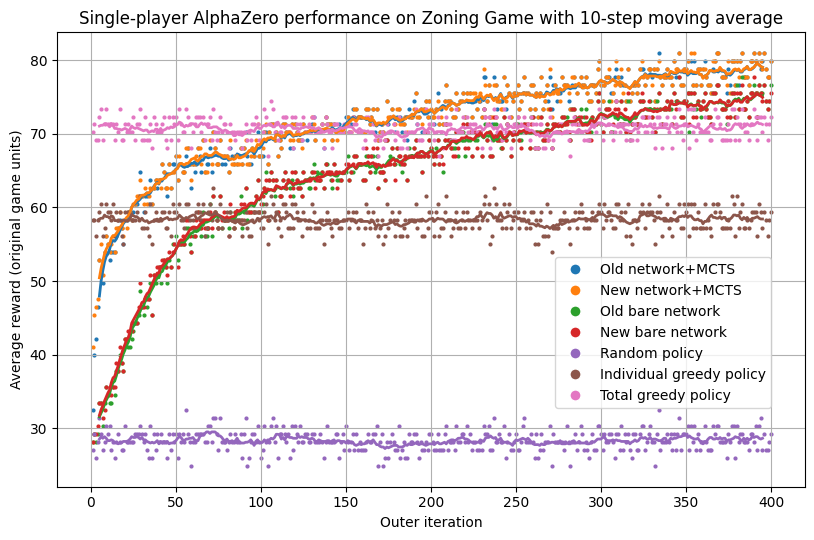

In [3]:
iterations = [entry['iteration'] for entry in results]
win_pcts = [entry['win_pct'] for entry in results]

BEST_FIT_WINDOW = min(100, len(iterations)//2)
SCATTER_SIZE = 4
LEGEND_MARKERSIZE = 8
XMIN = -int(len(iterations)*0.05)
XMAX = int(len(iterations)*1.05)
XSCALE = 6*6*3

# Moving average config
MOVING_AVG_WINDOW = 10  # Set default window width
MOVING_AVG_SHAPE = 'uniform'  # Options: 'uniform', 'triangular', 'gaussian'
MOVING_AVG_STD = 5  # Only used for gaussian

plt.figure(figsize=(8.25, 5.5))
# plt.figure(figsize=(30, 20))
ax1 = plt.gca()

# Use the order of first appearance for reward labels
reward_labels = reward_label_order

# Dictionary for renaming reward series (fill in as desired)
reward_label_rename = {
    # 'Old network+MCTS': 'Old Net + MCTS',
    # 'New network+MCTS': 'New Net + MCTS',
    # 'Old bare network': 'Old Net (bare)',
    # 'New bare network': 'New Net (bare)',
    'External policy "random"': 'Random policy',
    'External policy "individual greedy"': 'Individual greedy policy',
    'External policy "total greedy"': 'Total greedy policy',
}

# Build a dict of series for each label
reward_series = {label: [] for label in reward_labels}
for entry in results:
    for label in reward_labels:
        if 'rewards' in entry and label in entry['rewards']:
            reward_series[label].append(entry['rewards'][label]['avg']*XSCALE)
        else:
            reward_series[label].append(np.nan)  # Use np.nan for missing values

keep_iters = [entry['iteration'] for entry in results if entry['decision'] == 'keep']

# Assign unique color to each label for both scatter and fit
colors = plt.get_cmap('tab10')
color_map = {}
for idx, label in enumerate(reward_labels):
    color_map[label] = colors(idx % 10)

def plot_reward_series_with_fit(ax, x, y, label, color, display_label, best_fit_window=100, scatter_size=4, moving_avg_window=15, moving_avg_shape='uniform', moving_avg_std=5, do_best_fit=True):
    """Plot scatter, moving average, and best fit line with markers for a reward series on the given axes."""
    import numpy as np
    # SCATTER PLOT
    ax.scatter(x, y, label=display_label, s=scatter_size, color=color)

    # MOVING AVERAGE
    y_ma = moving_average(y, moving_avg_window, shape=moving_avg_shape, std=moving_avg_std)
    ax.plot(x, y_ma, color=color, linestyle='-', linewidth=2, label=f"_nolegend_")

    # LINE OF BEST FIT
    if do_best_fit:
        valid_points = [(xi, vi) for xi, vi in zip(x, y) if not np.isnan(vi)]
        if len(valid_points) >= 2:
            x_valid, y_valid = zip(*valid_points)
            x_fit = np.array(x_valid[-best_fit_window:])
            y_fit = np.array(y_valid[-best_fit_window:])
            x_full = np.array(range(0, XMAX))
            if not any(np.isnan(v) for v in y_fit):
                z = np.polyfit(x_fit, y_fit, 1)
                p = np.poly1d(z)
                ax.plot(x_full, p(x_full), color=color, label='_nolegend_')
                # Bracket markers for fit window
                ax.plot(x_fit[0], p(x_fit[0]), marker="<", color=color, markersize=8, linestyle='None', label='_nolegend_')
                ax.plot(x_fit[-1], p(x_fit[-1]), marker=">", color=color, markersize=8, linestyle='None', label='_nolegend_')

from matplotlib.lines import Line2D
legend_handles = []
legend_labels = []

for idx, label in enumerate(reward_labels):
    y = reward_series[label]
    display_label = reward_label_rename.get(label, label)
    plot_reward_series_with_fit(
        ax1, iterations, y, label, color_map[label], display_label,
        best_fit_window=BEST_FIT_WINDOW, scatter_size=SCATTER_SIZE,
        moving_avg_window=MOVING_AVG_WINDOW, moving_avg_shape=MOVING_AVG_SHAPE, moving_avg_std=MOVING_AVG_STD,
        do_best_fit=False
    )
    legend_handles.append(Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[label], markersize=LEGEND_MARKERSIZE, linestyle='None', label=display_label))
    legend_labels.append(display_label)

plt.xlim([XMIN, XMAX])
plt.legend(handles=legend_handles, labels=legend_labels, loc='upper right', bbox_to_anchor=(0.964, 0.52))
plt.xlabel('Outer iteration')
# plt.ylabel('Average reward (rescaled to original game units)')
plt.ylabel('Average reward (original game units)')
# plt.title(f'Game performance on test set with {MOVING_AVG_WINDOW}-step moving average')
plt.title(f'Single-player AlphaZero performance on Zoning Game with {MOVING_AVG_WINDOW}-step moving average')
plt.grid(True)
plt.tight_layout()
plt.savefig("zgaz_performance.png", dpi=1500)
plt.show()

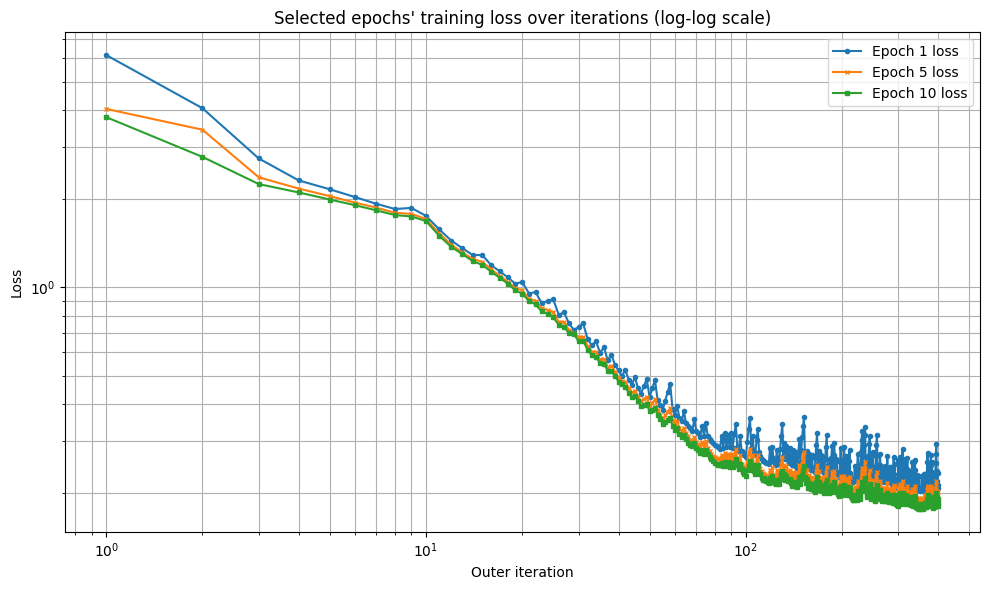

In [4]:
# Loss plots (unchanged, now in a separate figure)
epoch1_losses = [entry['epoch1_loss'] for entry in results]
epoch5_losses = [entry.get('epoch5_loss', None) for entry in results]
if 'epoch10_loss' in results[0]: epoch10_losses = [entry['epoch10_loss'] for entry in results]
if 'epoch20_loss' in results[0]: epoch20_losses = [entry.get('epoch20_loss', None) for entry in results]

plt.figure(figsize=(10, 6))
plt.plot(iterations, epoch1_losses, label='Epoch 1 loss', marker='o', markersize=3)
plt.plot(iterations, epoch5_losses, label='Epoch 5 loss', marker='x', markersize=3)
if 'epoch10_loss' in results[0]: plt.plot(iterations, epoch10_losses, label='Epoch 10 loss', marker='s', markersize=3)
if 'epoch20_loss' in results[0]: plt.plot(iterations, epoch20_losses, label='Epoch 20 loss', marker='^', markersize=3)

# plt.xlim(left=0)
plt.legend(loc='upper right')
plt.xlabel('Outer iteration')
plt.ylabel('Loss')
plt.title('Selected epochs\' training loss over iterations (log-log scale)')
plt.yscale('log')
plt.xscale('log')
plt.grid(True, which='both', axis='both')
plt.tight_layout()
plt.show()

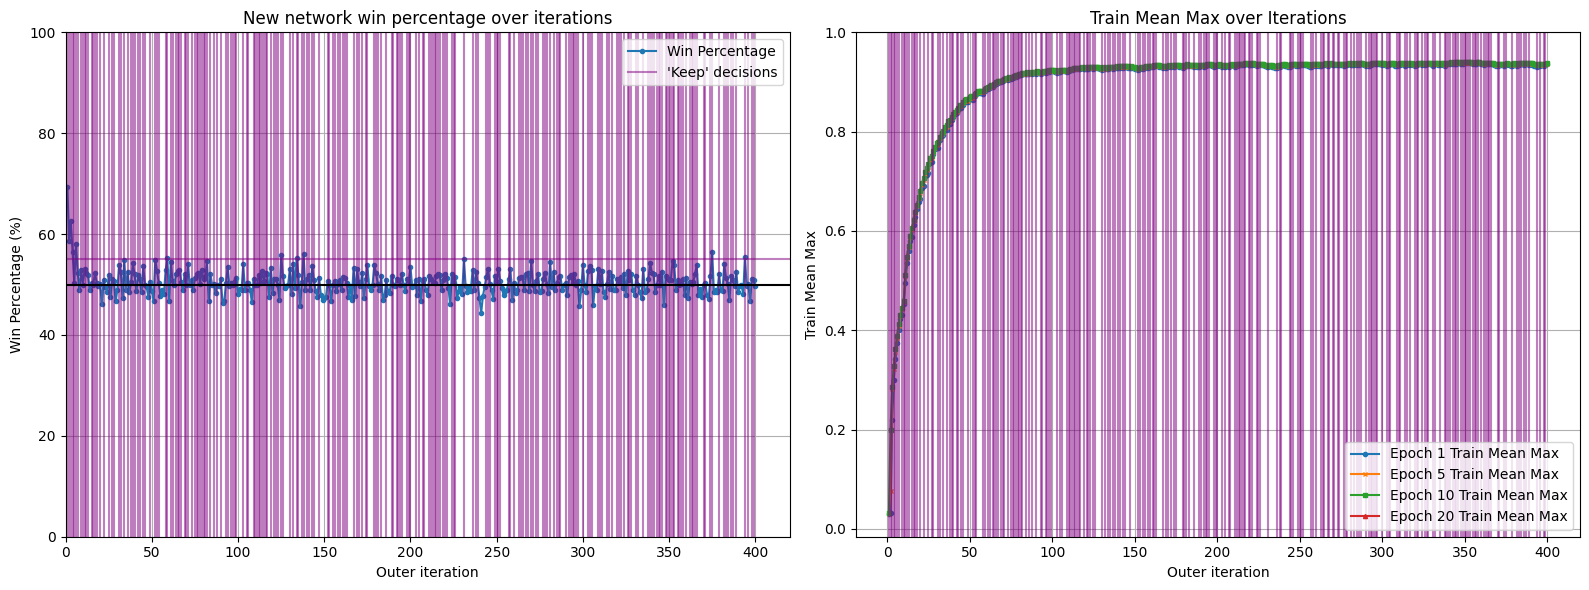

In [5]:
# Combined plot: Win percentage and Train Mean Max over iterations (side by side)
import matplotlib.pyplot as plt

iterations = [entry['iteration'] for entry in results]
win_pcts = [entry['win_pct'] for entry in results]
epoch1_mean_max = [entry.get('epoch1_mean_max', None) for entry in results]
epoch5_mean_max = [entry.get('epoch5_mean_max', None) for entry in results]
epoch10_mean_max = [entry.get('epoch10_mean_max', None) for entry in results]
epoch20_mean_max = [entry.get('epoch20_mean_max', None) for entry in results]

fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Win percentage
axs[0].plot(iterations, win_pcts, label='Win Percentage', marker='o', markersize=3)
for ki in keep_iters:
    axs[0].axvline(x=ki, color='purple', alpha=0.5)
axs[0].axhline(y=55, color='purple', alpha=0.5)
axs[0].axhline(y=50, color='black')
axs[0].axvline(x=-1, color='purple', alpha=0.5, label="'Keep' decisions")
axs[0].set_xlim([0, None])
axs[0].set_ylim([0, 100])
axs[0].legend()
axs[0].set_xlabel('Outer iteration')
axs[0].set_ylabel('Win Percentage (%)')
axs[0].set_title('New network win percentage over iterations')
axs[0].grid(True)

# Subplot 2: Train Mean Max
axs[1].plot(iterations, epoch1_mean_max, label='Epoch 1 Train Mean Max', marker='o', markersize=3)
axs[1].plot(iterations, epoch5_mean_max, label='Epoch 5 Train Mean Max', marker='x', markersize=3)
axs[1].plot(iterations, epoch10_mean_max, label='Epoch 10 Train Mean Max', marker='s', markersize=3)
axs[1].plot(iterations, epoch20_mean_max, label='Epoch 20 Train Mean Max', marker='^', markersize=3)
for ki in keep_iters:
    axs[1].axvline(x=ki, color='purple', alpha=0.5)
axs[1].set_xlabel('Outer iteration')
axs[1].set_ylabel('Train Mean Max')
axs[1].set_title('Train Mean Max over Iterations')
axs[1].legend()
axs[1].grid(True)
axs[1].set_ylim(top=1.0)

plt.tight_layout()
plt.show()

## Misc

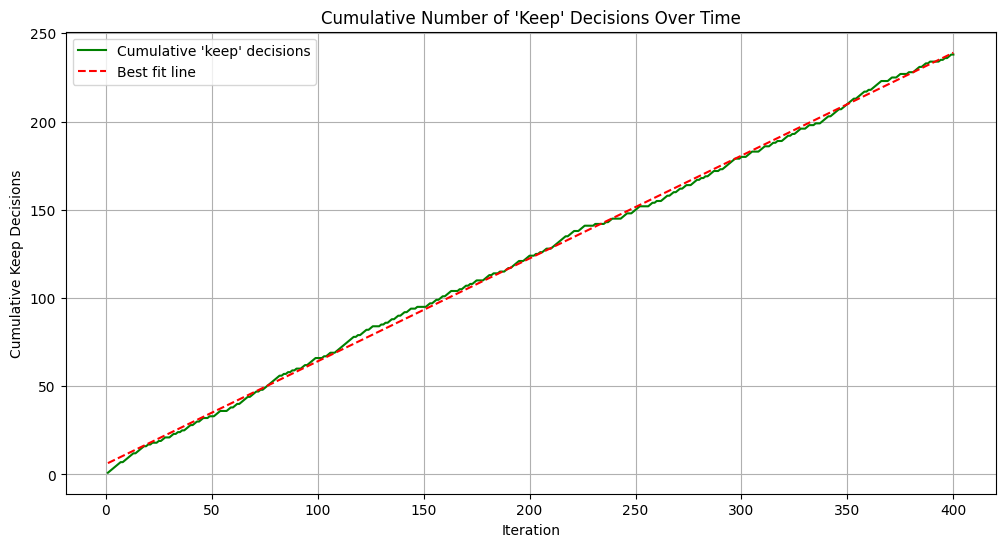

In [6]:
# Calculate cumulative sum of 'keep' decisions over iterations
keep_mask = [1 if entry['decision'] == 'keep' else 0 for entry in results]
cumulative_keep = np.cumsum(keep_mask)

plt.figure(figsize=(12, 6))
plt.plot(iterations, cumulative_keep, label="Cumulative 'keep' decisions", color='green')
plt.xlabel('Iteration')
plt.ylabel('Cumulative Keep Decisions')
plt.title("Cumulative Number of 'Keep' Decisions Over Time")
plt.grid(True)
# plt.legend()
# Plot line of best fit
z = np.polyfit(iterations, cumulative_keep, 1)
p = np.poly1d(z)
plt.plot(iterations, p(iterations), "r--", label="Best fit line")
plt.legend()
plt.show()

In [7]:
import numpy as np

games_times = [entry.get('games_time') for entry in results if 'games_time' in entry]
train_times = [entry.get('train_time') for entry in results if 'train_time' in entry]
eval_times = [entry.get('eval_time') for entry in results if 'eval_time' in entry]

def print_time_stats(times, label):
    if times:
        total_s = np.sum(times)
        avg_s = np.mean(times)
        total_m = total_s / 60
        avg_m = avg_s / 60
        total_h = total_s / 3600
        avg_h = avg_s / 3600
        print(f"{label} - Total: {total_s:.2f} s | {total_m:.2f} min | {total_h:.2f} hr")
        print(f"{label} - Average: {avg_s:.2f} s | {avg_m:.2f} min | {avg_h:.2f} hr (Count: {len(times)})")
    else:
        print(f"{label} - No data found.")

print_time_stats(games_times, 'Games time')
print_time_stats(train_times, 'Train time')
print_time_stats(eval_times, 'Eval time')

Games time - Total: 18269.98 s | 304.50 min | 5.07 hr
Games time - Average: 45.67 s | 0.76 min | 0.01 hr (Count: 400)
Train time - Total: 27161.61 s | 452.69 min | 7.54 hr
Train time - Average: 67.90 s | 1.13 min | 0.02 hr (Count: 400)
Eval time - Total: 6235.48 s | 103.92 min | 1.73 hr
Eval time - Average: 15.59 s | 0.26 min | 0.00 hr (Count: 400)


In [8]:
# Compute and print average iteration time (game+train+eval) and total time across all iterations
import numpy as np

iteration_times = []
for entry in results:
    g = entry.get('games_time', 0.0)
    t = entry.get('train_time', 0.0)
    e = entry.get('eval_time', 0.0)
    if any(k in entry for k in ['games_time', 'train_time', 'eval_time']):
        iteration_times.append(g + t + e)

if iteration_times:
    total_iter_s = np.sum(iteration_times)
    avg_iter_s = np.mean(iteration_times)
    total_iter_m = total_iter_s / 60
    avg_iter_m = avg_iter_s / 60
    total_iter_h = total_iter_s / 3600
    avg_iter_h = avg_iter_s / 3600
    print(f"Iteration time (games+train+eval) - Total: {total_iter_s:.2f} s | {total_iter_m:.2f} min | {total_iter_h:.2f} hr")
    print(f"Iteration time (games+train+eval) - Average: {avg_iter_s:.2f} s | {avg_iter_m:.2f} min | {avg_iter_h:.2f} hr (Count: {len(iteration_times)})")
else:
    print("Iteration time (games+train+eval) - No data found.")

Iteration time (games+train+eval) - Total: 51667.07 s | 861.12 min | 14.35 hr
Iteration time (games+train+eval) - Average: 129.17 s | 2.15 min | 0.04 hr (Count: 400)
